In [1]:
# this part is for the nondetrend plots
from mailbox import _PartialFile
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo
import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

import metpy.calc as mpcalc
import metpy.constants as constants
import geocat.comp
from windspharm.xarray import VectorWind
import skill_metrics as sm
from brokenaxes import brokenaxes

reload(sepl)

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy import signal
from eofs.multivariate.standard import MultivariateEof
from eofs.standard import Eof

# read the data
#   read data from observation and reanalysis data

fpreGPCP = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/GPCP_r144x72_197901-201412.nc"
)
preGPCP = fpreGPCP["precip"]
preGPCP_JJA = ca.p_time(preGPCP, 6, 8, True)

preAIR = xr.open_dataarray("/home/ys17-23/Extension/All_India_Rainfall_index/AIR_mmperday.nc")
preAIR_JJA = ca.p_time(preAIR, 6, 8, True)
preAIR_JJA = preAIR_JJA.sel(time=(preAIR_JJA.time.dt.year>=1979) & (preAIR_JJA.time.dt.year <=2014))


fhgtERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/hgt_mon_r144x72_195001-201412.nc")
hgtERA5 = fhgtERA5["z"].sel(time=fhgtERA5["time"].dt.year>=1979)

fuERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/uwind_mon_r144x72_195001-201412.nc"
)
uERA5 = fuERA5["u"].sel(time=fuERA5["time"].dt.year>=1979)

fvERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/vwind_mon_r144x72_195001-201412.nc"
)
vERA5 = fvERA5["v"].sel(time=fvERA5["time"].dt.year>=1979)

fspERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/sp_mon_r144x72_195001-201412.nc"
)
spERA5 = fspERA5["sp"].sel(time=fspERA5["time"].dt.year>=1979)

fqERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/q_mon_r144x72_195001-201412.nc")
qERA5 = fqERA5["q"].sel(time=fqERA5["time"].dt.year>=1979)

fwERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/omega_mon_r144x72_195001-201412.nc")
wERA5 = fwERA5["w"].sel(time=fwERA5["time"].dt.year>=1979)

fsstHad = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/HadISST_r144x72_1870-2020.nc")
sstHad = fsstHad["sst"].sel(time=(fsstHad["time"].dt.year>=1979) & (fsstHad["time"].dt.year<=2014))

hgtERA5_ver_JJA = ca.p_time(hgtERA5, 6, 8, True)
hgtERA5_ver_JJA = hgtERA5_ver_JJA-hgtERA5_ver_JJA.mean(dim="lon", skipna=True)
uERA5_ver_JJA = ca.p_time(uERA5, 6, 8, True)
vERA5_ver_JJA = ca.p_time(vERA5, 6, 8, True)
qERA5_ver_JJA = ca.p_time(qERA5, 6, 9, True)
spERA5_JJA = ca.p_time(spERA5, 6, 8, True)
wERA5_JJA = ca.p_time(wERA5, 6, 8, True)
sstHad_JJA = ca.p_time(sstHad, 6, 8, True)

ftERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/temp_mon_r144x72_195001-201412.nc")
tERA5 = ftERA5["t"].sel(time=ftERA5["time"].dt.year>=1979)
tERA5_ver_JJA = ca.p_time(tERA5, 6, 8, True)

divERA5_ver_JJA = ca.cal_divergence(uERA5_ver_JJA.sel(level=[200.0, 850.0]), vERA5_ver_JJA.sel(level=[200.0, 850.0]))

# read the data from CMIP6 historical experiment
# fprehis = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/pr_historical_r144x72_195001-201412.nc")
# prehis_JJA = fprehis["pr"].sel(time=fprehis["time"].dt.year>=1979)
# prehis_JJA.attrs["units"] = "mm/day"
# prehis_JJA.attrs["standard_name"] = "precipitation"

# fhgthis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/zg_historical_r144x72_195001-201412.nc")
# hgthis_ver_JJA = fhgthis_ver_JJA["zg"].sel(time=fhgthis_ver_JJA["time"].dt.year>=1979)
# hgthis_ver_JJA = hgthis_ver_JJA - hgthis_ver_JJA.mean(dim="lon", skipna=True)

fuhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/ua_historical_r144x72_195001-201412.nc")
uhis_ver_JJA = fuhis_ver_JJA["ua"].sel(time=fuhis_ver_JJA["time"].dt.year>=1979)

fvhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/va_historical_r144x72_195001-201412.nc")
vhis_ver_JJA = fvhis_ver_JJA["va"].sel(time=fvhis_ver_JJA["time"].dt.year>=1979)

# fwhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/wap_historical_r144x72_195001-201412.nc") 
# whis_ver_JJA = fwhis_ver_JJA["wap"].sel(time=fwhis_ver_JJA["time"].dt.year>=1979)

# fssthis_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/tos_historical_r144x72_195001-201412.nc")
# ssthis_JJA = fssthis_JJA["tos"].sel(time=fssthis_JJA["time"].dt.year>=1979)

# fthis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/ta_historical_r144x72_195001-201412.nc")
# this_ver_JJA = fthis_ver_JJA["ta"].sel(time=fthis_ver_JJA["time"].dt.year>=1979)

# read the data from CMIP6 ssp585 experiment and read the last period of ssp585
# fpressp585 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/pr_ssp585_r144x72_201501-209912.nc")
# pressp585_JJA = fpressp585["pr"]
# pressp585_JJA.attrs["units"] = "mm/day"
# pressp585_JJA.attrs["standard_name"] = "precipitation"
# # pressp585_p3_JJA = fpressp585_p3["pr"].sel(time=fpressp585_p3.time.dt.year>=2064)
# # pressp585_p3_JJA.attrs["units"] = "mm/day"
# # pressp585_p3_JJA.attrs["standard_name"] = "precipitation"

# fhgtssp585_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/zg_ssp585_r144x72_201501-209912.nc")
# hgtssp585_ver_JJA = fhgtssp585_ver_JJA["zg"].sel(time=fhgtssp585_ver_JJA.time.dt.year>=2064)
# hgtssp585_ver_JJA = hgtssp585_ver_JJA - hgtssp585_ver_JJA.mean(dim="lon", skipna=True)


fussp585_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ua_ssp585_r144x72_201501-209912.nc")
ussp585_ver_JJA = fussp585_ver_JJA["ua"]

fvssp585_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/va_ssp585_r144x72_201501-209912.nc")
vssp585_ver_JJA = fvssp585_ver_JJA["va"]

# fwssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/wap_ssp585_r144x72_201501-209912.nc")
# wssp585_p3_ver_JJA = fwssp585_p3_ver_JJA["wap"].sel(time=fwssp585_p3_ver_JJA.time.dt.year>=2064)

# fsstssp585_p3_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/tos_ssp585_r144x72_201501-209912.nc")
# sstssp585_p3_JJA = fsstssp585_p3_JJA["tos"].sel(time=fsstssp585_p3_JJA.time.dt.year>=2064)

# ftssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ta_ssp585_r144x72_201501-209912.nc")
# tssp585_p3_ver_JJA = ftssp585_p3_ver_JJA["ta"].sel(time=ftssp585_p3_ver_JJA.time.dt.year>=2064)

# divhis_ver_JJA = ca.cal_divergence(uhis_ver_JJA.sel(level=[200.0, 850.0]), vhis_ver_JJA.sel(level=[200.0, 850.0]))
# divssp585_p3_ver_JJA = ca.cal_divergence(ussp585_p3_ver_JJA.sel(level=[200.0, 850.0]), vssp585_p3_ver_JJA.sel(level=[200.0, 850.0]))
# #   deal with the time index for CRU and GPCP data
# # preCRU_JJA.coords["time"] = prehis_JJA.coords["time"]
# preGPCP_JJA.coords["time"] = prehis_JJA.sel(time=prehis_JJA.time.dt.year>=1979).coords["time"]
# preAIR_JJA.coords["time"] = prehis_JJA.coords["time"]

models = uhis_ver_JJA.coords["models"]
models_array = models.data

#   pick up the area data
#   calculate the vorticity in ERA5, historical and ssp585
# vorERA5_ver_JJA = mpcalc.vorticity(uERA5_ver_JJA.sel(level=200.0), vERA5_ver_JJA.sel(level=200.0))
# vorERA5_ver_JJA = vorERA5_ver_JJA.metpy.dequantify()

# vorhis_ver_JJA = mpcalc.vorticity(uhis_ver_JJA.sel(level=200.0), vhis_ver_JJA.sel(level=200.0))
# vorhis_ver_JJA = vorhis_ver_JJA.metpy.dequantify()

# vorssp585_p3_ver_JJA = mpcalc.vorticity(ussp585_p3_ver_JJA.sel(level=200.0), vssp585_p3_ver_JJA.sel(level=200.0))
# vorssp585_p3_ver_JJA = vorssp585_p3_ver_JJA.metpy.dequantify()

# #   calculate the precipitation in India
# lat = preGPCP_JJA.coords["lat"]
# lon = preGPCP_JJA.coords["lon"]

# India_N = 32.5
# # India_N = 30.0
# India_S = 7.5
# India_W = 70.0
# India_E = 85.0
# lat_India_range = lat[(lat >= India_S) & (lat <= India_N)]
# lon_India_range = lon[(lon >= India_W) & (lon <= India_E)]

# # preCRU_India_JJA = ca.cal_lat_weighted_mean(preCRU_JJA.sel(lat=lat_India_range, lon=lon_India_range)).mean(dim="lon", skipna=True)
# preGPCP_India_JJA = ca.cal_lat_weighted_mean(preGPCP_JJA.sel(lat=lat_India_range, lon=lon_India_range)).mean(dim="lon", skipna=True)
# # preGPCP_India_JJA = ca.standardize(preGPCP_India_JJA)
# # preAIR_JJA = ca.standardize(preAIR_JJA)
# prehis_India_JJA = ca.cal_lat_weighted_mean(prehis_JJA.sel(lat=lat_India_range, lon=lon_India_range)).mean(dim="lon", skipna=True)
# # prehis_India_JJA = ca.standardize(prehis_India_JJA)
# pressp585_p3_India_JJA = ca.cal_lat_weighted_mean(pressp585_p3_JJA.sel(lat=lat_India_range, lon=lon_India_range)).mean(dim="lon", skipna=True)
# # pressp585_p3_India_JJA =  ca.standardize(pressp585_p3_India_JJA)
# prehis_India_JJA_sum = ca.cal_lat_weighted_mean(prehis_JJA.sel(lat=lat_India_range, lon=lon_India_range)).sum(dim="lon", skipna=True)*len(lat_India_range)
# pressp585_p3_India_JJA_sum = ca.cal_lat_weighted_mean(pressp585_p3_JJA.sel(lat=lat_India_range, lon=lon_India_range)).sum(dim="lon", skipna=True)*len(lat_India_range)


# prehis_India_JJA_fraction = (prehis_JJA.sel(lat=lat_India_range, lon=lon_India_range)*np.cos(np.deg2rad(lat_India_range))/prehis_India_JJA_sum).mean(dim="time", skipna=True)
# pressp585_p3_India_JJA_fraction = (pressp585_p3_JJA.sel(lat=lat_India_range, lon=lon_India_range)*np.cos(np.deg2rad(lat_India_range))/pressp585_p3_India_JJA_sum).mean(dim="time", skipna=True)
# prediff_India_JJA_fraction = pressp585_p3_India_JJA_fraction - prehis_India_JJA_fraction

# select the good models and calculate the gMME
gmodels = ["CAMS-CSM1-0", "CESM2-WACCM", "CMCC-ESM2", "INM-CM4-8", "MRI-ESM2-0", "UKESM1-0-LL"]
# prehis_India_JJA_fraction_gens = prehis_India_JJA_fraction.sel(models=gmodels).mean(dim="models", skipna=True)
# pressp585_p3_India_JJA_fraction_gens = pressp585_p3_India_JJA_fraction.sel(models=gmodels).mean(dim="models", skipna=True)
# prediff_India_JJA_fraction_gens = pressp585_p3_India_JJA_fraction_gens - prehis_India_JJA_fraction_gens

# # try to do the test
# prehis_India_JJA_fraction_gens_mask = ca.MME_reg_mask(prehis_India_JJA_fraction_gens, prediff_India_JJA_fraction.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True)
# pressp585_p3_India_JJA_fraction_gens_mask = ca.MME_reg_mask(pressp585_p3_India_JJA_fraction_gens, prediff_India_JJA_fraction.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True)
# prediff_India_JJA_fraction_gens_mask = ca.cal_mmemask(prediff_India_JJA_fraction.sel(models=gmodels))

# concat the data of historical and ssp585
# u_for_eof = xr.concat([uhis])

In [2]:
# concat the data of historical and ssp585
u_for_eof = xr.concat([uhis_ver_JJA, ussp585_ver_JJA], "time").sel(level=200.0, models=gmodels).loc[:,:,20:60,30:170]
v_for_eof = xr.concat([vhis_ver_JJA, vssp585_ver_JJA], "time").sel(level=200.0, models=gmodels).loc[:,:,20:60,30:170]

In [3]:
# standardize the u and v
u_for_eof = ca.standardize(u_for_eof.mean(dim="models", skipna=True))
v_for_eof = ca.standardize(v_for_eof.mean(dim="models", skipna=True))

In [4]:
# concat the u and v
var_for_eof = xr.concat([u_for_eof, v_for_eof], "lon")

In [ ]:
var_for_eof

In [5]:
# calculate the MVEOF
EOFs, PCs, percentContrib = ca.eof_analyse(np.array(var_for_eof), np.array(var_for_eof.coords["lat"]), 1)

In [6]:
u_EOF1 = EOFs[0, :, :57]
v_EOF1 = EOFs[0, :, 57:]
u_EOF1 = xr.DataArray(
        u_EOF1, coords={"lat": u_for_eof.coords["lat"], "lon": u_for_eof.coords["lon"]}, dims=["lat", "lon"]
    )
v_EOF1 = xr.DataArray(
        v_EOF1, coords={"lat": v_for_eof.coords["lat"], "lon": v_for_eof.coords["lon"]}, dims=["lat", "lon"]
    )

<a list of 1 Line2D objects>

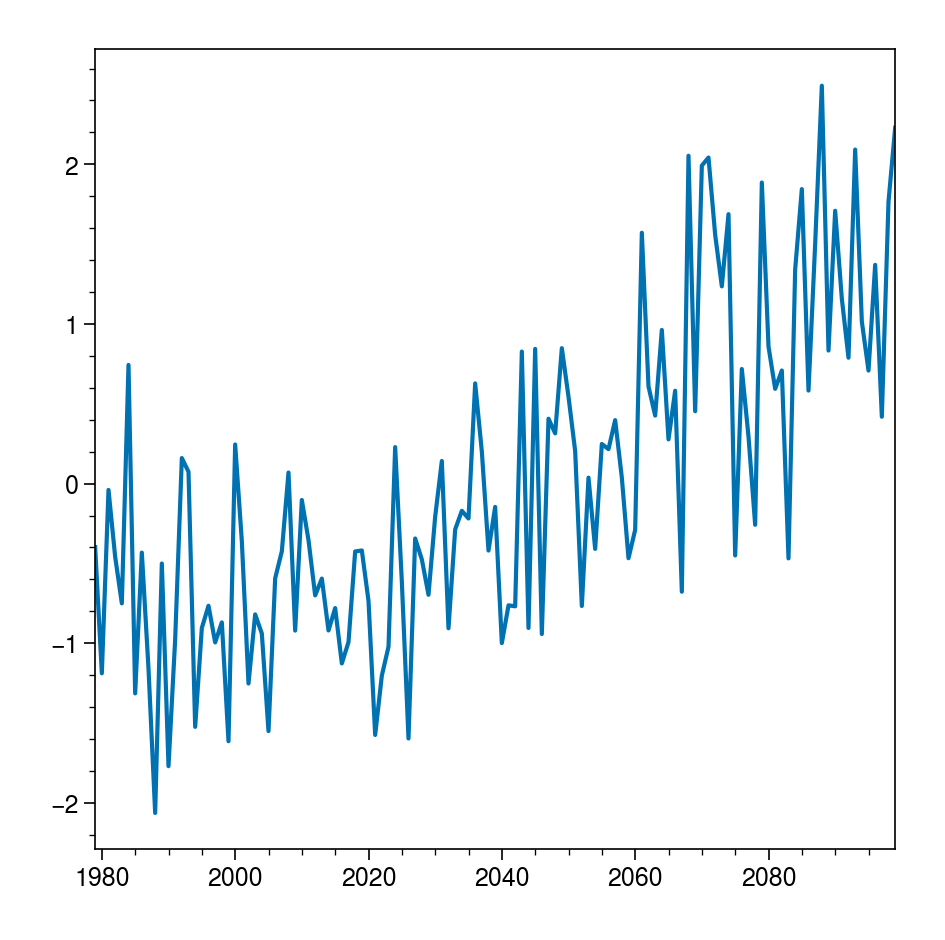

In [7]:
pplt.rc.grid = False
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"]

fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
axs = fig.subplots(ncols=1, nrows=1)

axs.line(np.arange(1979, 2100), PCs[:, 0])

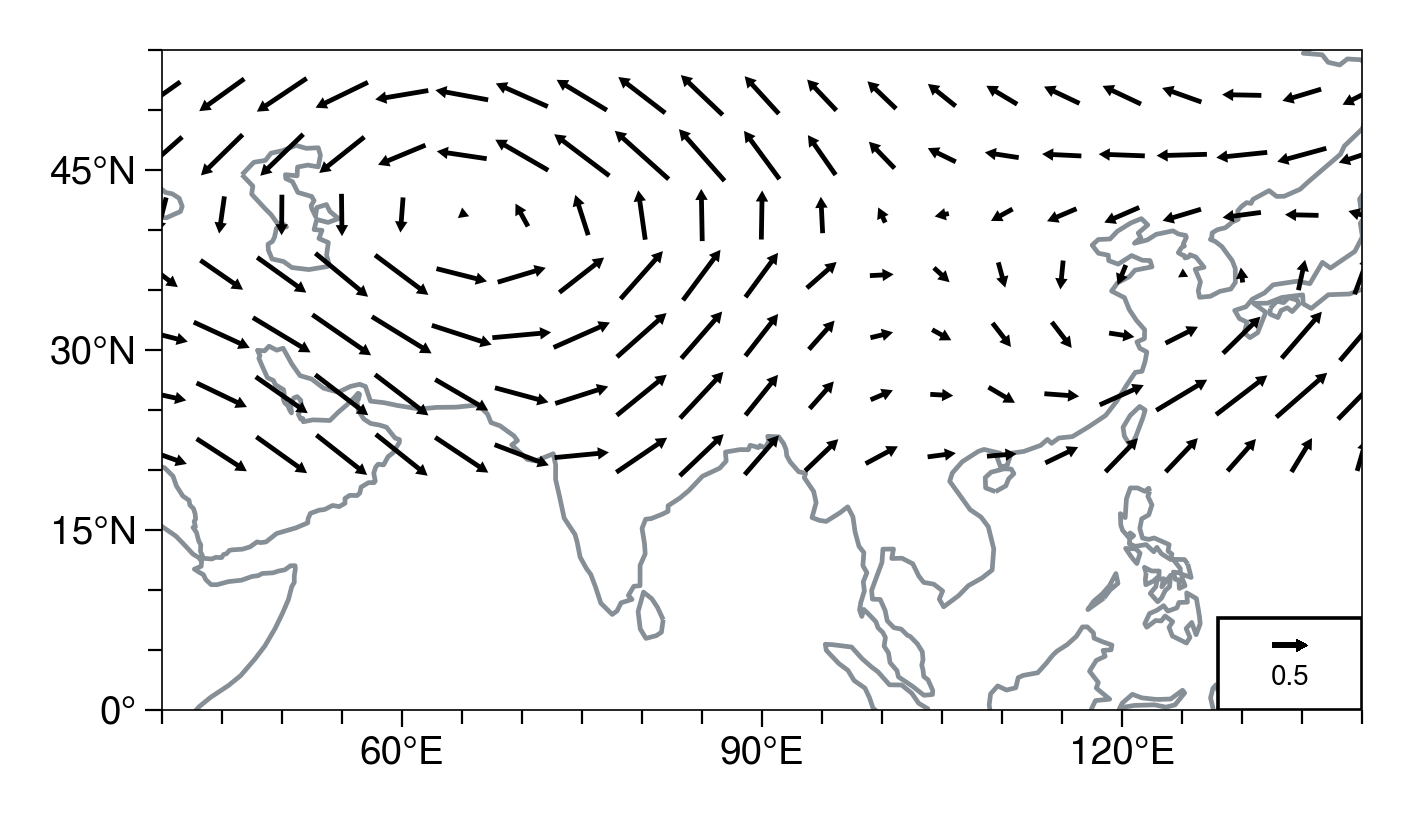

In [8]:
# plot the pattern
pplt.rc.grid = False
pplt.rc.reso = "lo"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"] = 15
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
# plot_array = np.reshape(range(1, 7), (3, 2))
# plot_array[-1,-1] = 0
axs = fig.subplots(ncols=1, nrows=1, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
    
m = axs[0].quiver(
        u_EOF1[::ski, ::ski],
        v_EOF1[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=0.17,
        pivot="mid",
        color="black",
    )

qk = axs[0].quiverkey(
    m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
)

In [10]:
# calculate EOF before MME
u_for_eof = xr.concat([uhis_ver_JJA, ussp585_ver_JJA], "time").sel(level=200.0, models=gmodels).loc[:,:,20:60,30:170]
v_for_eof = xr.concat([vhis_ver_JJA, vssp585_ver_JJA], "time").sel(level=200.0, models=gmodels).loc[:,:,20:60,30:170]
u_for_eof = ca.standardize(u_for_eof)
v_for_eof = ca.standardize(v_for_eof)
var_for_eof = xr.concat([u_for_eof, v_for_eof], "lon")

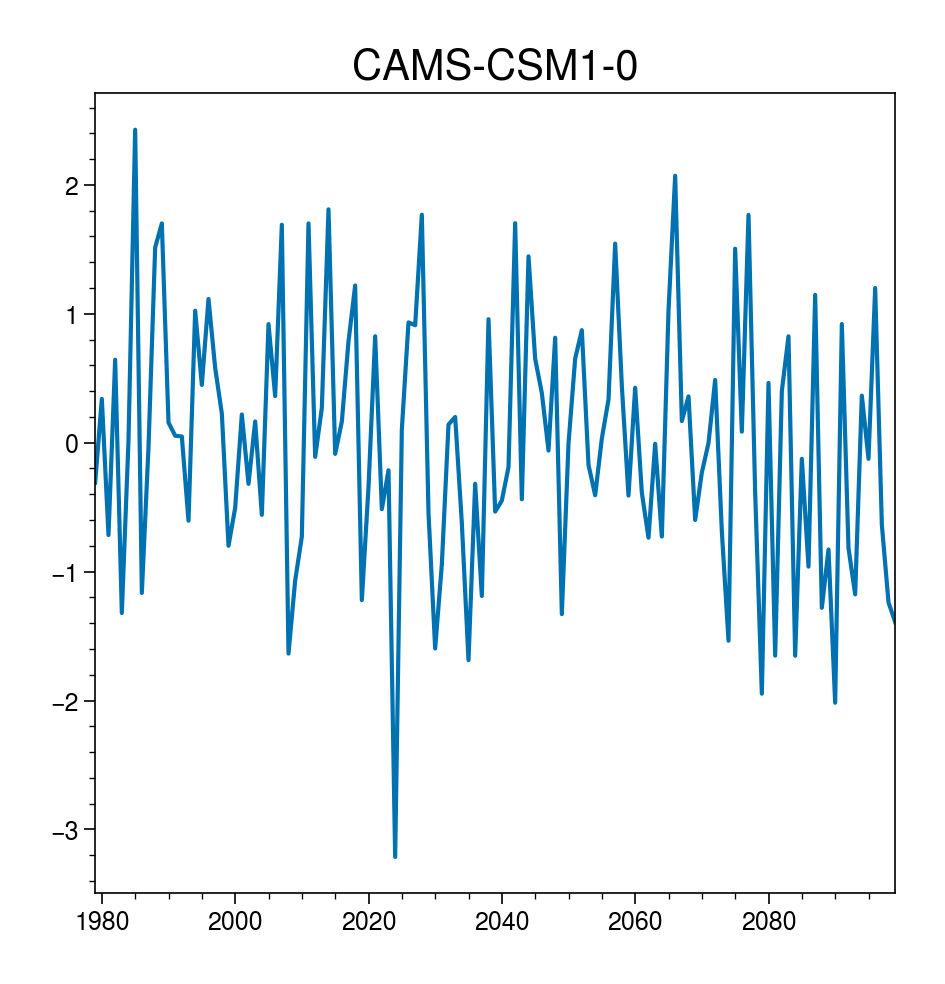

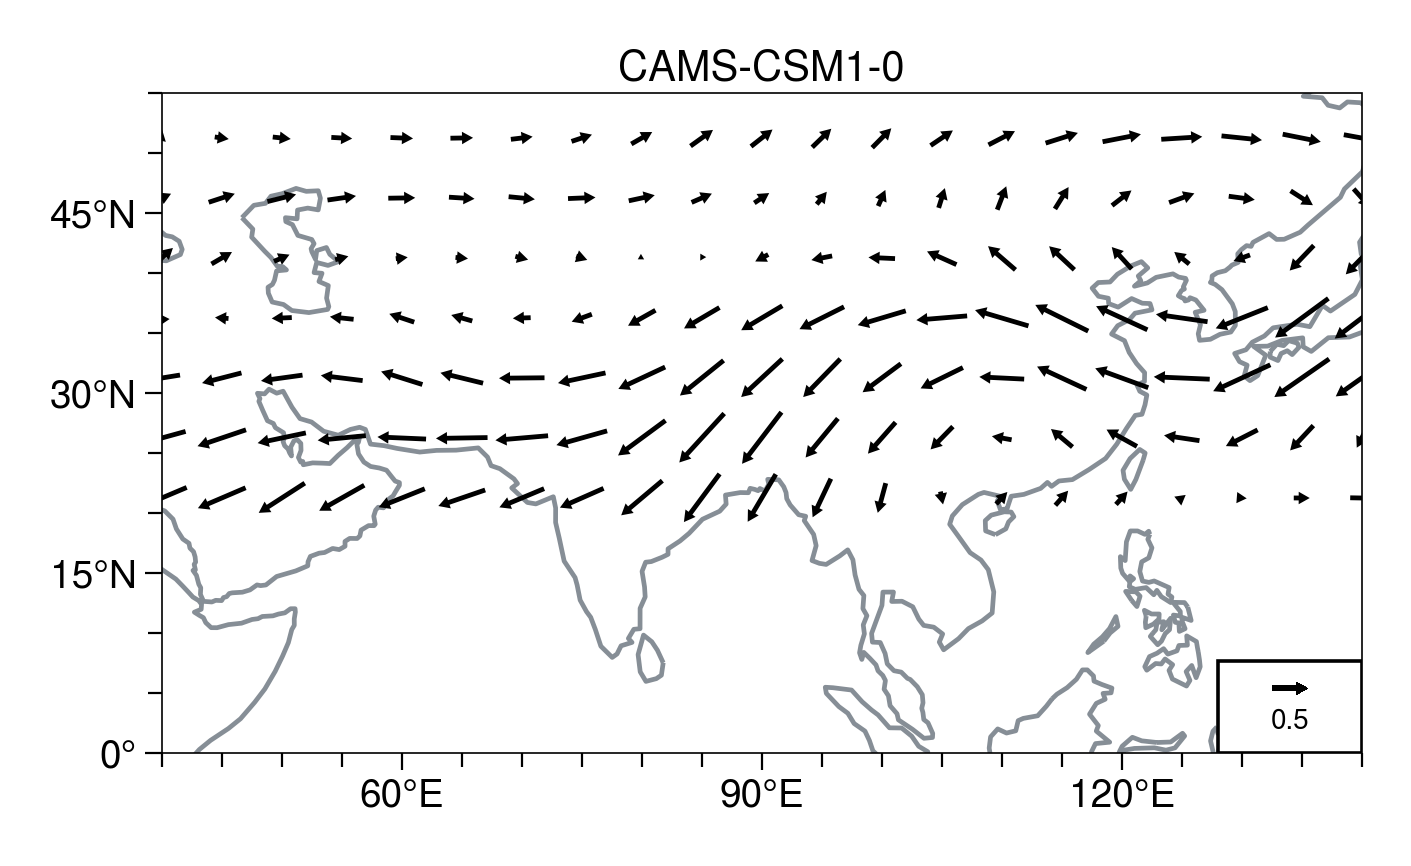

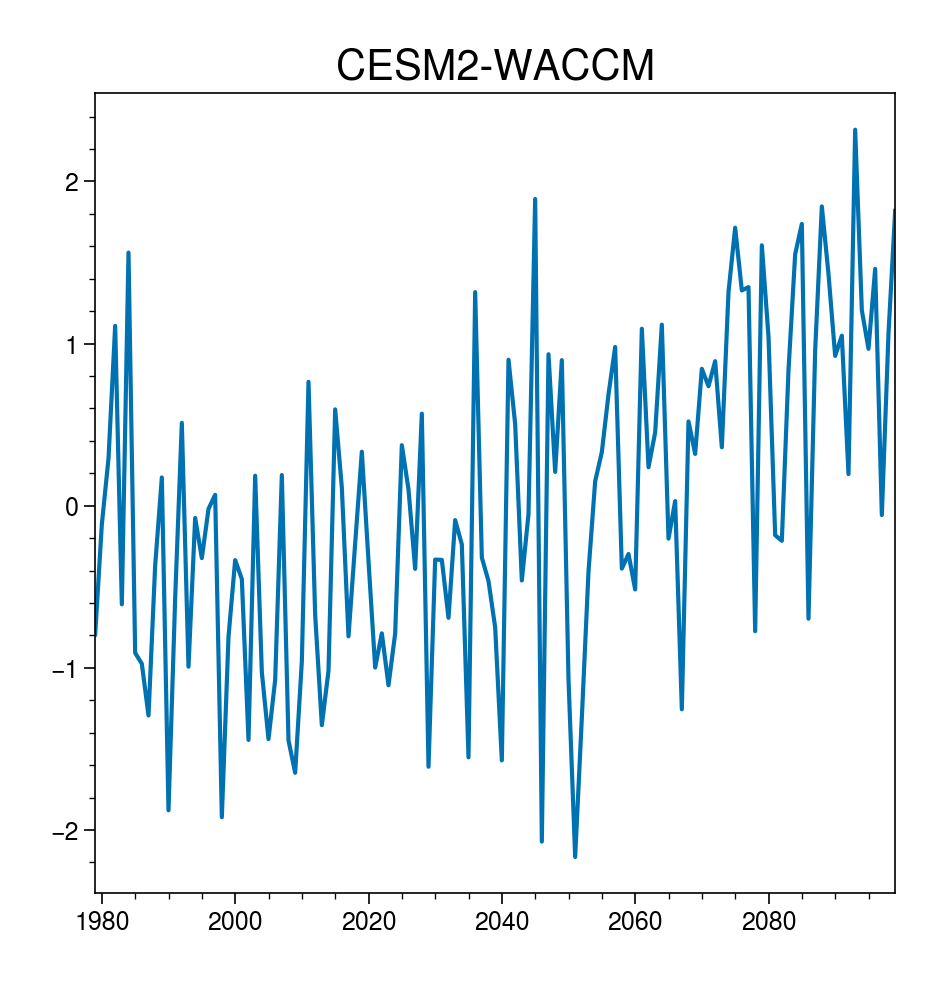

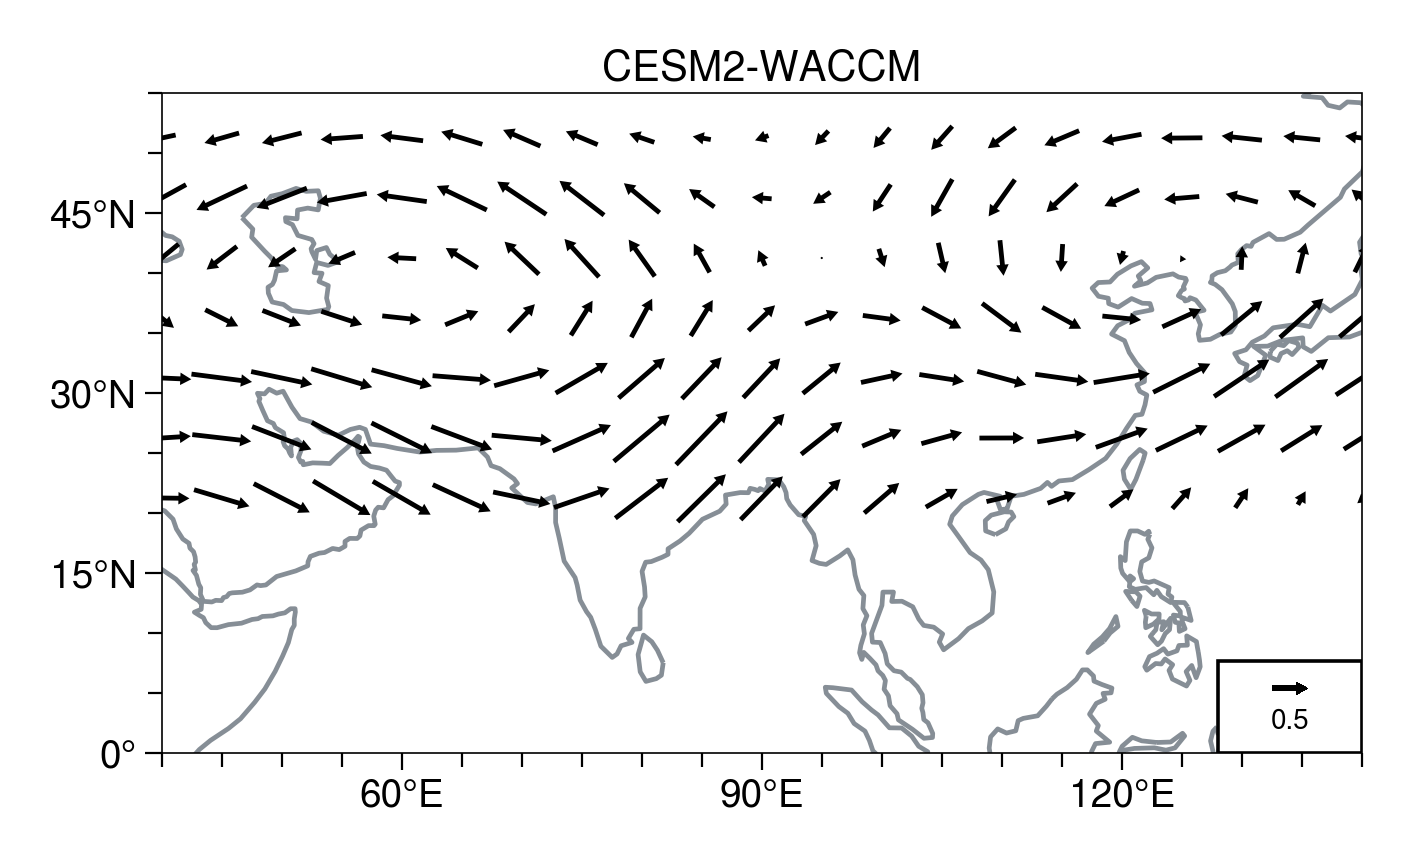

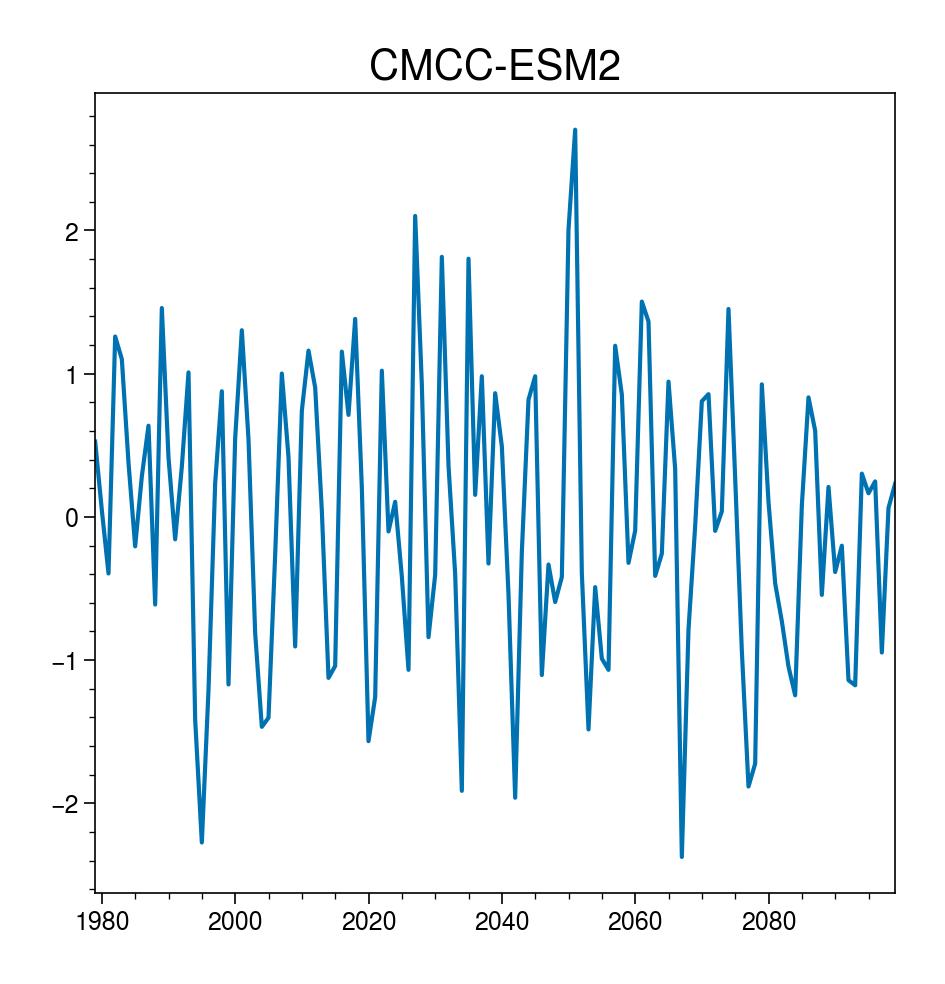

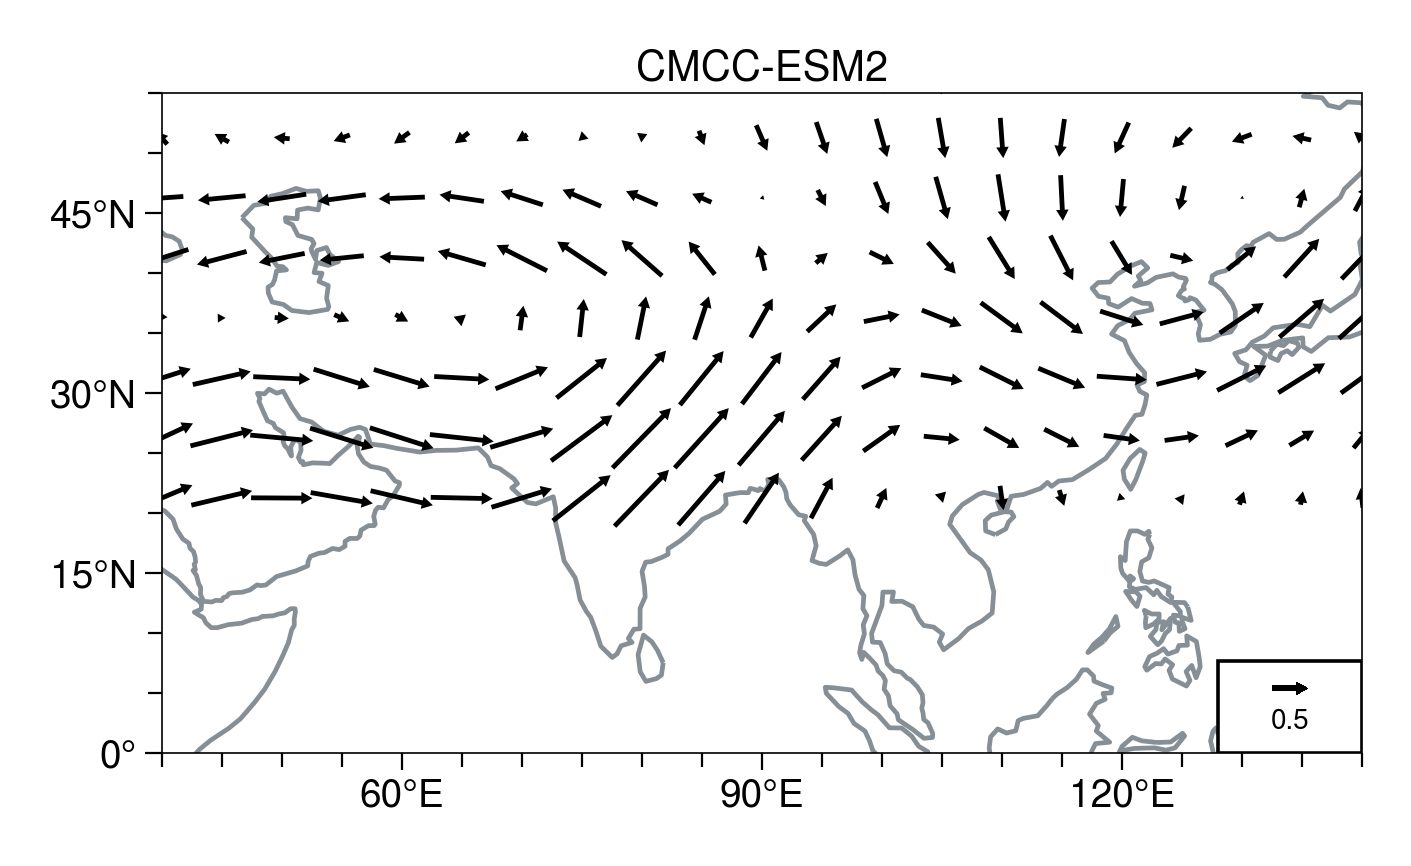

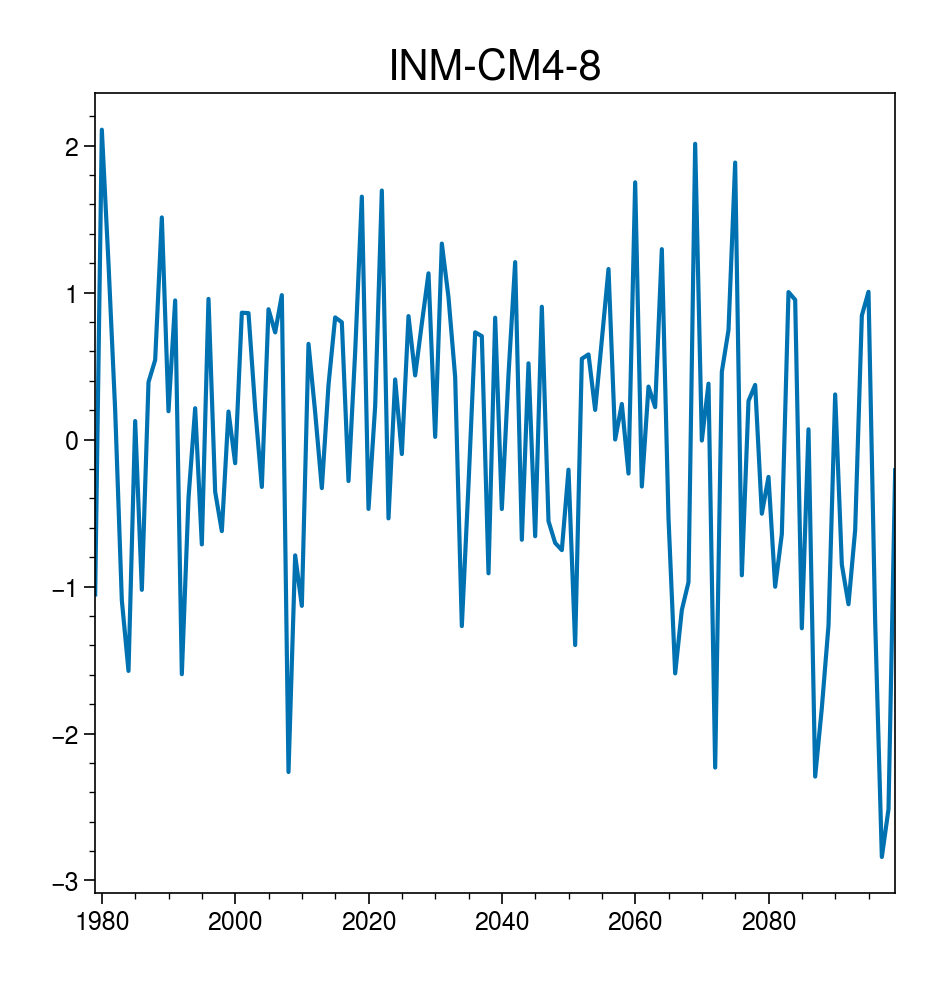

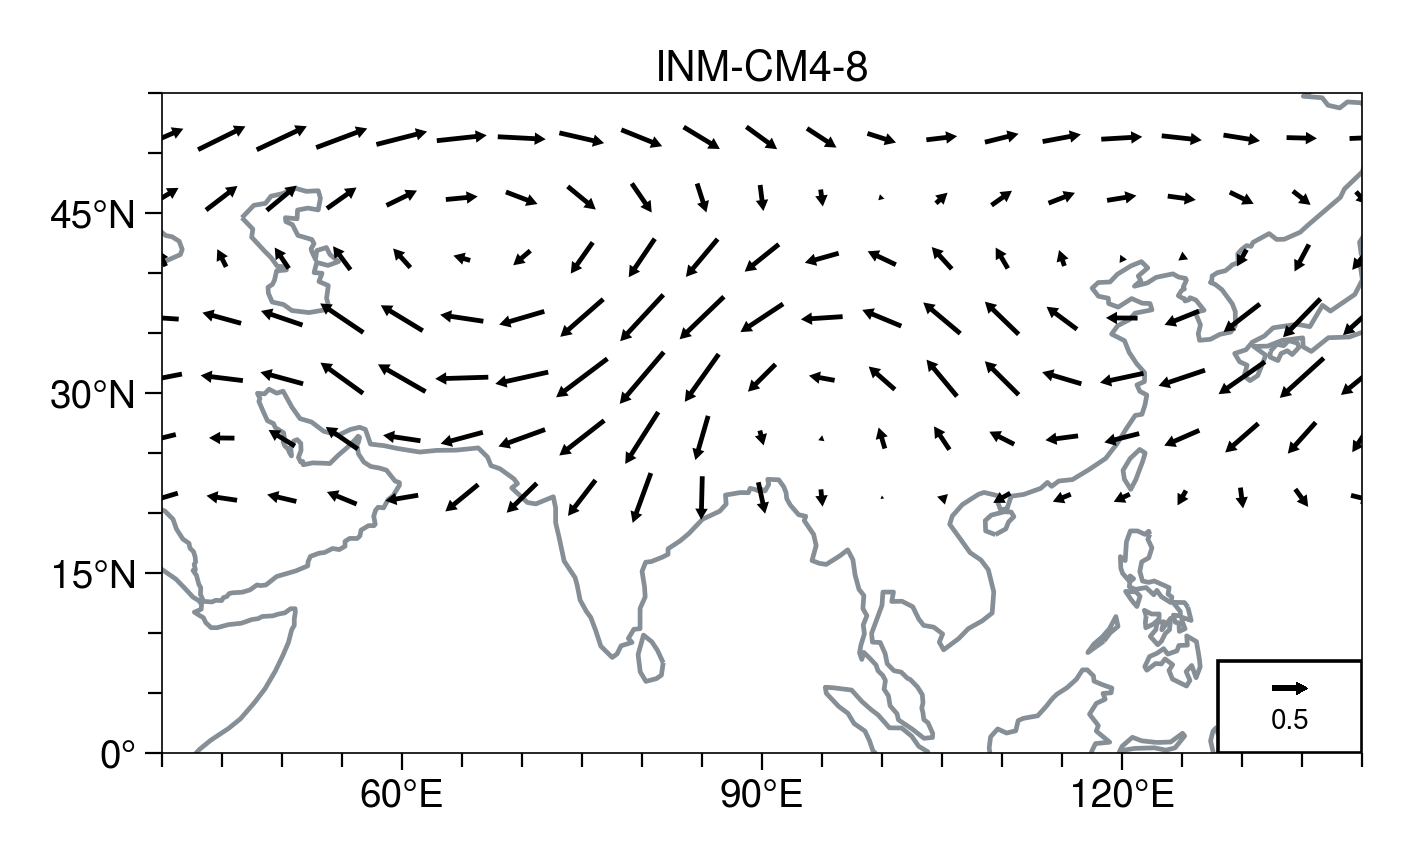

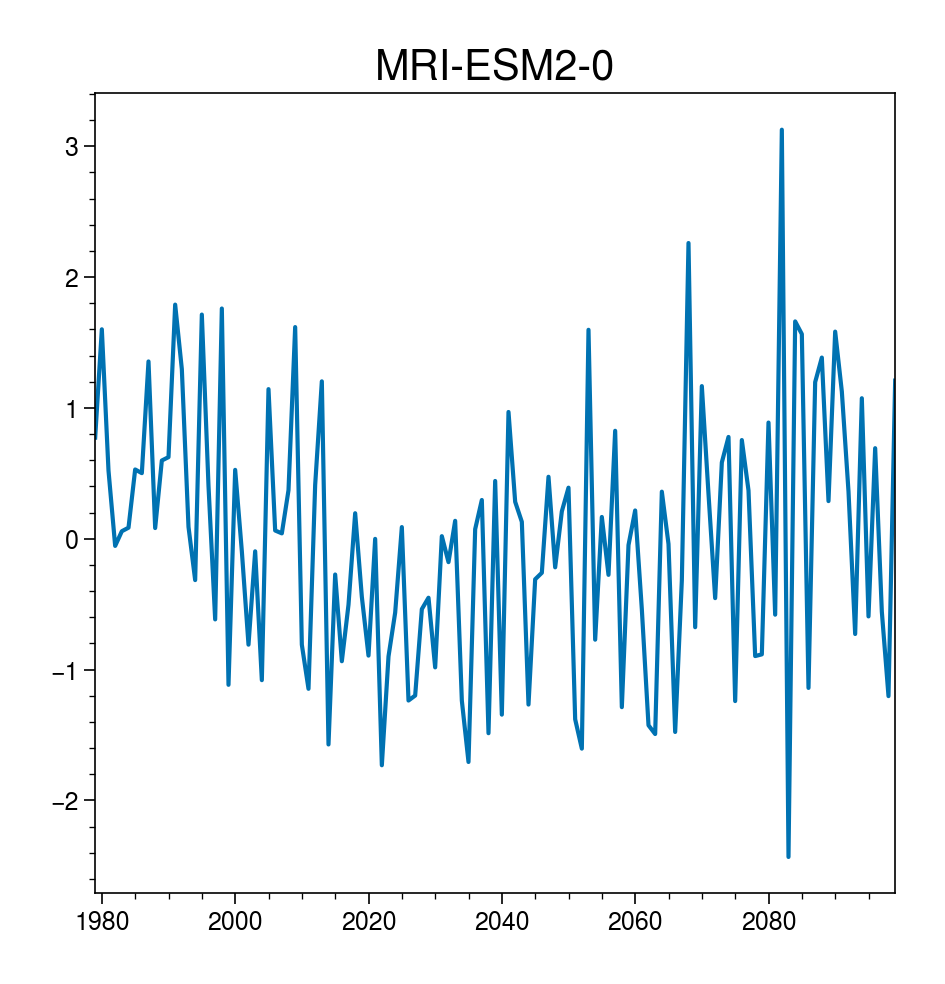

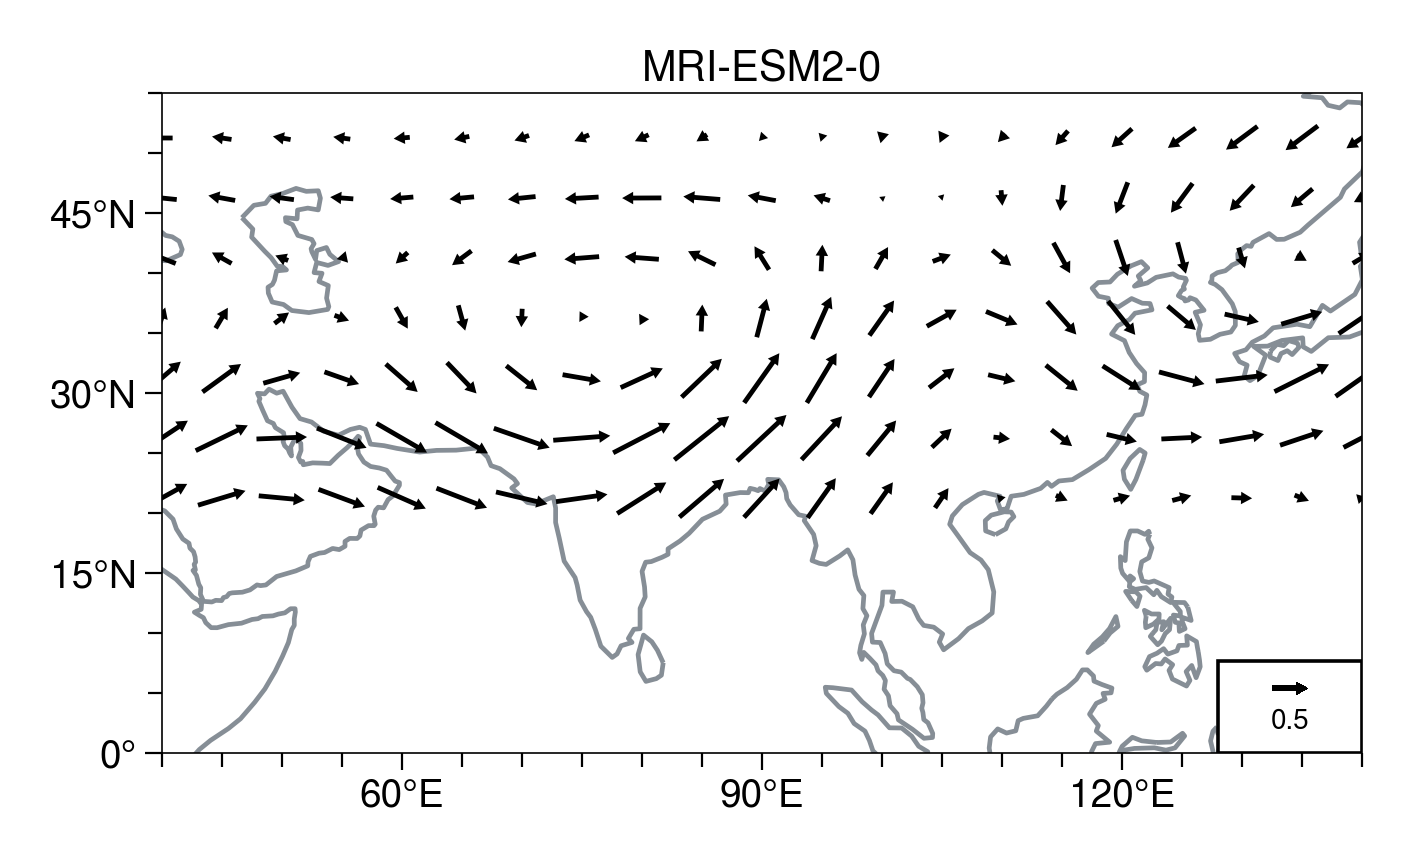

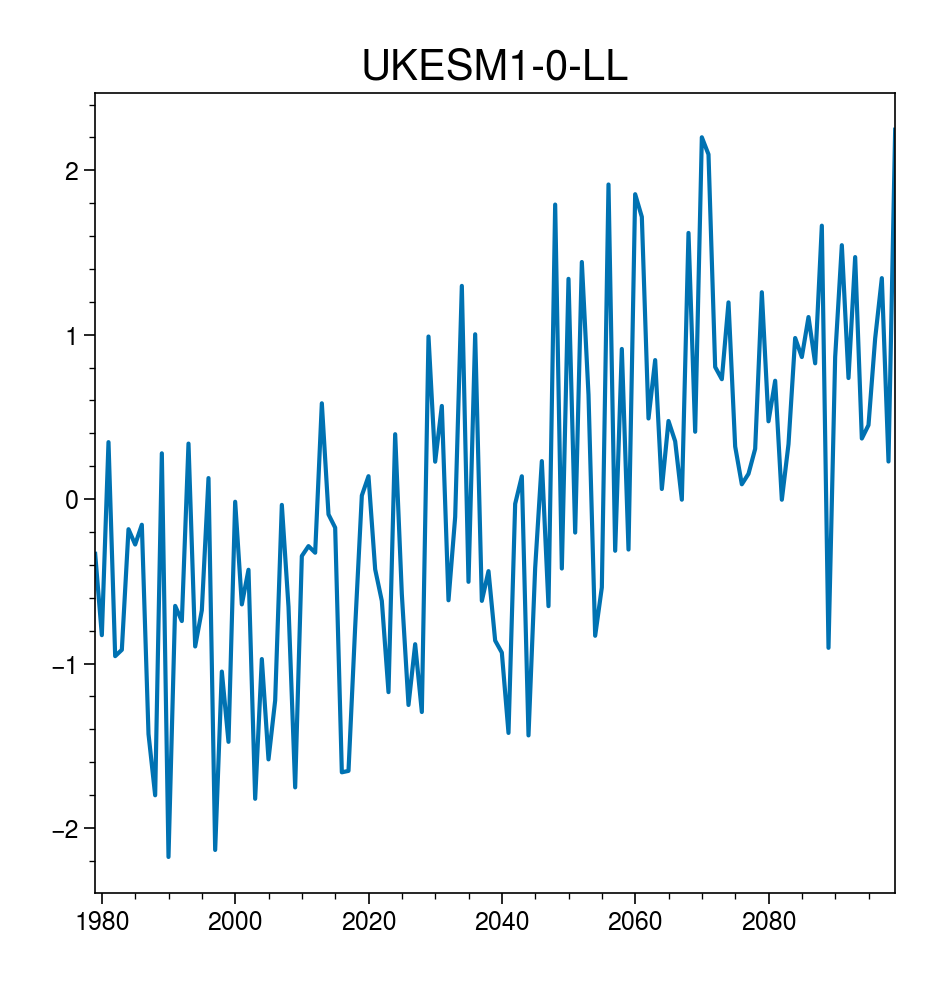

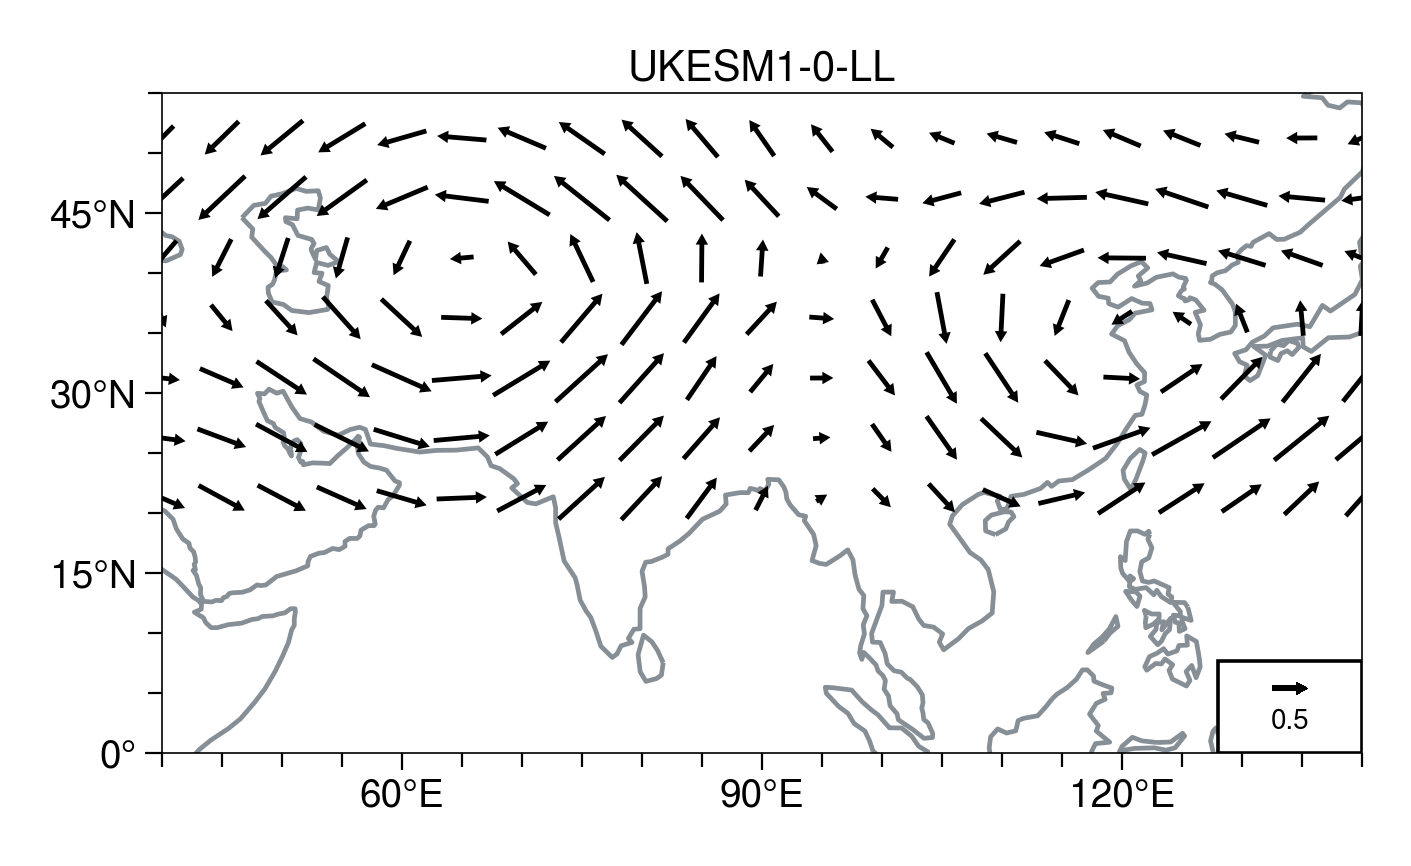

In [26]:
for i,mod in enumerate(gmodels):
  EOFs, PCs, percentContrib = ca.eof_analyse(np.array(var_for_eof.sel(models=mod)), np.array(var_for_eof.coords["lat"]), 1)
  u_EOF1 = EOFs[0, :, :57]
  v_EOF1 = EOFs[0, :, 57:]
  u_EOF1 = xr.DataArray(
          u_EOF1, coords={"lat": u_for_eof.coords["lat"], "lon": u_for_eof.coords["lon"]}, dims=["lat", "lon"]
      )
  v_EOF1 = xr.DataArray(
          v_EOF1, coords={"lat": v_for_eof.coords["lat"], "lon": v_for_eof.coords["lon"]}, dims=["lat", "lon"]
      )
  pplt.rc.grid = False
  pplt.rc["figure.facecolor"] = "white"
  pplt.rc["font.large"]

  fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
  axs = fig.subplots(ncols=1, nrows=1)

  axs.line(np.arange(1979, 2100), PCs[:, 0])
  axs.format(title=mod)
  
  # plot the pattern
  pplt.rc.grid = False
  pplt.rc.reso = "lo"
  pplt.rc["figure.facecolor"] = "white"
  pplt.rc["font.large"] = 15
  cl = 0  # 设置地图投影的中心纬度
  proj = pplt.PlateCarree(central_longitude=cl)

  fig = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
  # plot_array = np.reshape(range(1, 7), (3, 2))
  # plot_array[-1,-1] = 0
  axs = fig.subplots(ncols=1, nrows=1, proj=proj)

  #   set the geo_ticks and map projection to the plots
  # xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
  xticks = np.array([60, 90, 120])  # 设置纬度刻度
  yticks = np.arange(0, 46, 15)  # 设置经度刻度
  # 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
  # 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
  extents = [40.0, 140.0, yticks[0], 55.0]
  sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
  # ===================================================
  ski = 2
  n = 1
  w, h = 0.12, 0.14
  # ======================================
  for ax in axs:
      rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
      ax.add_patch(rect)
      
  m = axs[0].quiver(
          u_EOF1[::ski, ::ski],
          v_EOF1[::ski, ::ski],
          zorder=1.1,
          headwidth=2.6,
          headlength=2.3,
          headaxislength=2.3,
          minlength=0.5,
          width=0.004,
          scale_units="xy",
          scale=0.17,
          pivot="mid",
          color="black",
      )

  qk = axs[0].quiverkey(
      m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
  )
  axs[0].format(title=mod)

In [24]:
np.shape(percentContrib)
# np.shape(EOFs)

(121,)

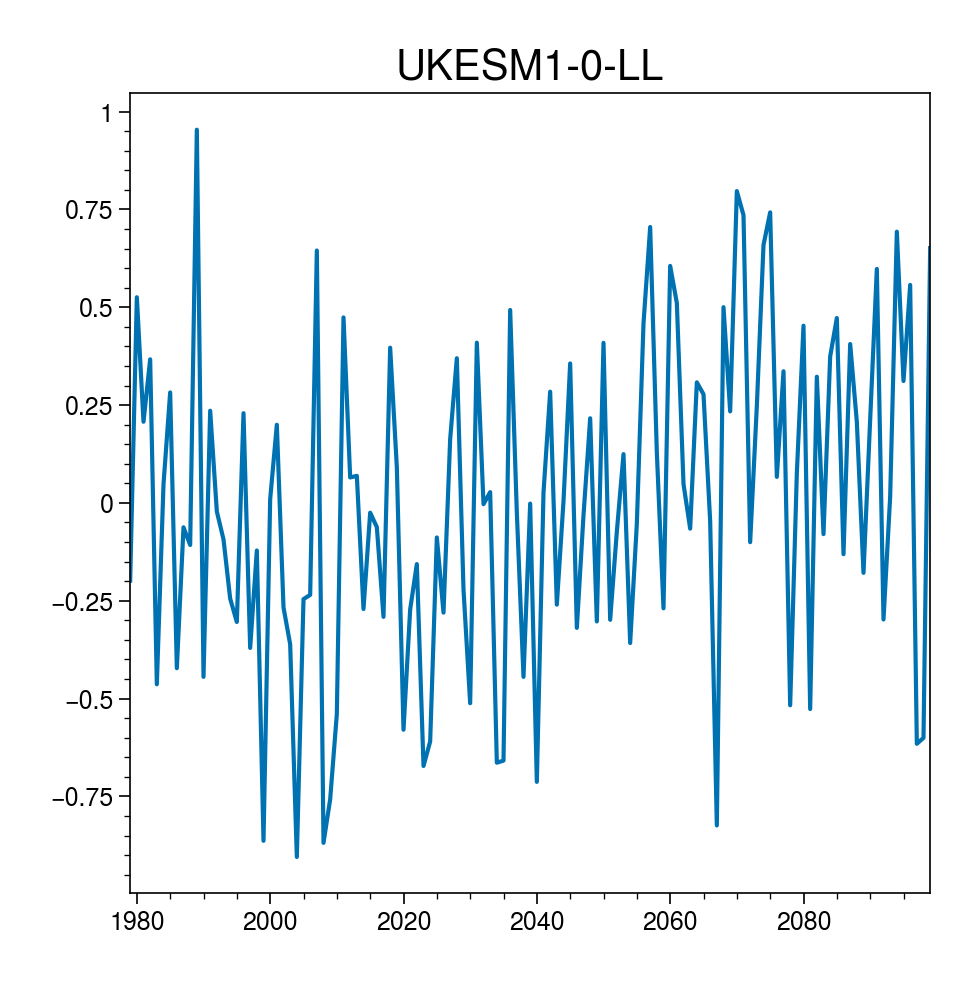

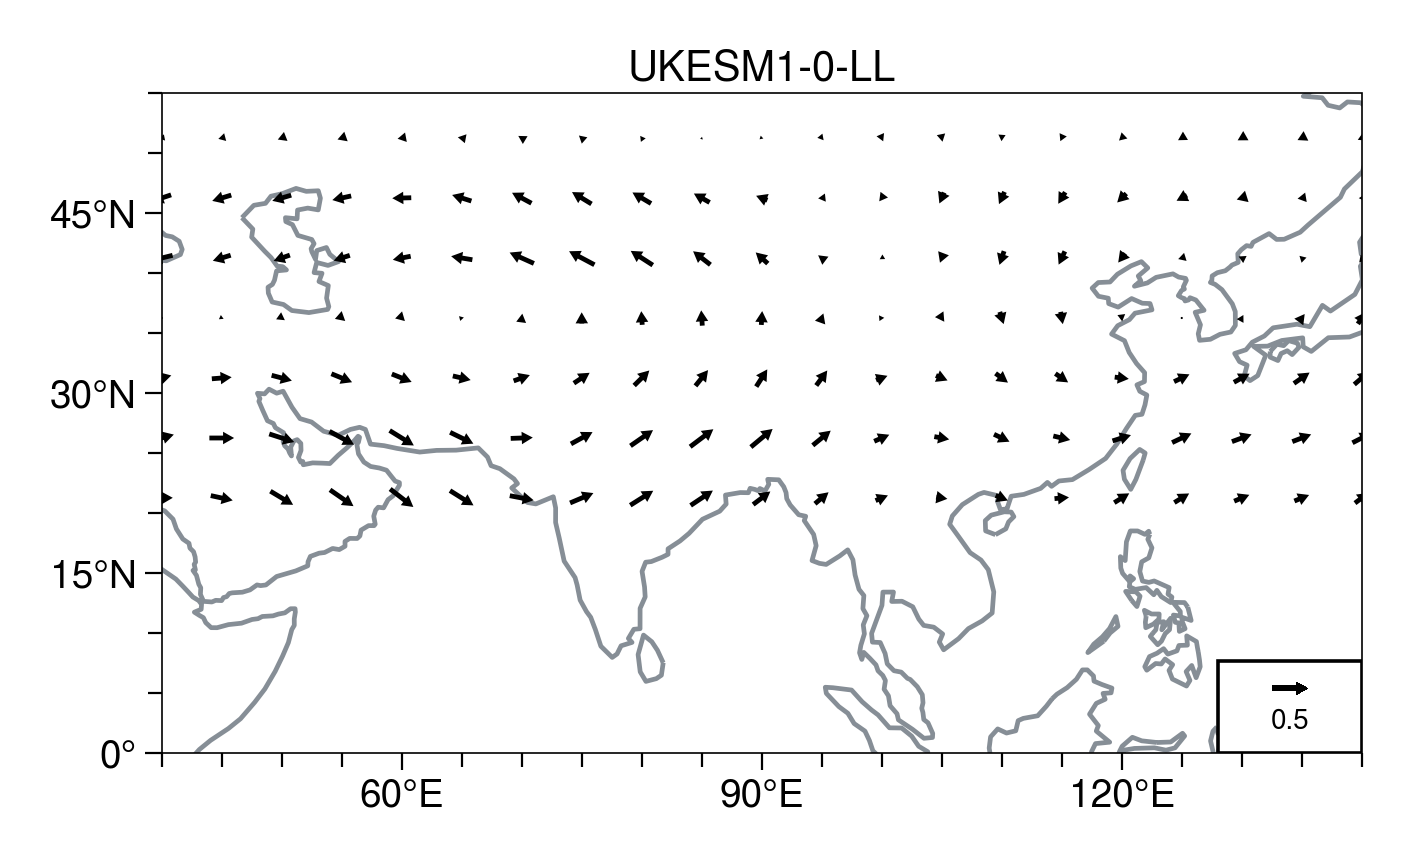

In [32]:
# plot the MME
EOFs = np.zeros([6,121,16,114])
PCs = np.zeros([6,121,1])
percentContrib = np.zeros([6,121])
for i,mod in enumerate(gmodels):
  EOFs[i,:,:,:], PCs[i,:,:], percentContrib[i,:] = ca.eof_analyse(np.array(var_for_eof.sel(models=mod)), np.array(var_for_eof.coords["lat"]), 1)

u_EOF1 = EOFs[:, 0, :, :57]
v_EOF1 = EOFs[:, 0, :, 57:]
u_EOF1 = xr.DataArray(
        u_EOF1, coords={"models": gmodels, "lat": u_for_eof.coords["lat"], "lon": u_for_eof.coords["lon"]}, dims=["models", "lat", "lon"]
    )
v_EOF1 = xr.DataArray(
        v_EOF1, coords={"models": gmodels, "lat": v_for_eof.coords["lat"], "lon": v_for_eof.coords["lon"]}, dims=["models", "lat", "lon"]
    )

u_EOF1_MME = u_EOF1.mean(dim="models", skipna=True)
v_EOF1_MME = v_EOF1.mean(dim="models", skipna=True)
PCs_MME = np.mean(PCs,axis=0)

pplt.rc.grid = False
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"]

fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
axs = fig.subplots(ncols=1, nrows=1)

axs.line(np.arange(1979, 2100), PCs_MME[:, 0])
axs.format(title=mod)

# plot the pattern
pplt.rc.grid = False
pplt.rc.reso = "lo"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"] = 15
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
# plot_array = np.reshape(range(1, 7), (3, 2))
# plot_array[-1,-1] = 0
axs = fig.subplots(ncols=1, nrows=1, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
    
m = axs[0].quiver(
        u_EOF1_MME[::ski, ::ski],
        v_EOF1_MME[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=0.17,
        pivot="mid",
        color="black",
    )

qk = axs[0].quiverkey(
    m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
)
axs[0].format(title=mod)

In [29]:
np.shape(u_EOF1_MME)

(16, 57)

In [31]:
np.shape(PCs_MME)

(121, 1)

In [33]:
exit

: 